## Predição risco de credito

Este projeto tem como objetivo analisar os dados e criar modelos preditivos para previsão de risco de credito, visando reduzir o risco de perdas monetarias

## Imports

In [147]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score,roc_curve, confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt
import seaborn as sns

import shap

In [148]:
# Carregar dataset
import os
data_path = os.path.join("assets", "dataset.csv")
df = pd.read_csv(data_path)
print(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dataset carregado com 1000 linhas e 21 colunas.


### Analise exploratória e limpeza dos dados

Nessa seção, buscamos identificar valores ausentes e duplicados para que possamos trata-los. Procuramos por padrões e possiveis correções que possam melhorar a analise dos dados

Informações gerais, verificando se há presença de dados duplicados ou vazios

In [149]:
# Verificar tipos de dados e valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   id                                                        1000 non-null   int64 
 1   Duration in months                                        1000 non-null   int64 
 2   Credit history                                            1000 non-null   object
 3   Purpose of the credit                                     1000 non-null   object
 4   Credit amount                                             1000 non-null   int64 
 5   Status of savings account/bonds                           1000 non-null   object
 6   Present employment(years)                                 1000 non-null   object
 7   Installment rate in percentage of disposable income       1000 non-null   int64 
 8   personal_status              

In [150]:
# Verificar duplicados e valores nulos
print(f"valores nulos:\n{df.isna().sum()}")
print(f"\n\nvalores duplicados: {df.duplicated().sum()}")

valores nulos:
id                                                          0
Duration in months                                          0
Credit history                                              0
Purpose of the credit                                       0
Credit amount                                               0
Status of savings account/bonds                             0
Present employment(years)                                   0
Installment rate in percentage of disposable income         0
personal_status                                             0
Other debtors / guarantors                                  0
Present residence since X years                             0
Property                                                    0
Age in years                                                0
Other installment plans (banks/stores)                      0
Housing                                                     0
Number of existing credits at this bank                

Não ha dados duplicados nem valores vazios presentes no dataset.

In [151]:
print(df.head())

   id  Duration in months                  Credit history  \
0   1                   6  critical/other existing credit   
1   2                  48                   existing paid   
2   3                  12  critical/other existing credit   
3   4                  42                   existing paid   
4   5                  24              delayed previously   

  Purpose of the credit  Credit amount Status of savings account/bonds  \
0              radio/tv           1169                no known savings   
1              radio/tv           5951                            <100   
2             education           2096                            <100   
3   furniture/equipment           7882                            <100   
4               new car           4870                            <100   

  Present employment(years)  \
0                       >=7   
1                    1<=X<4   
2                    4<=X<7   
3                    4<=X<7   
4                    1<=X<4   

 

Algumas colunas não acrecentam informações relevantes para o modelo, como as de id e telefone. Também é possivel notar que a coluna "personal_status" deveria estar separada em duas, genero e estado marital

In [152]:
#removendo colunas irrelevantes
df = df.drop(columns=['id','Telephone'])
print(df.columns)

Index(['Duration in months', 'Credit history', 'Purpose of the credit',
       'Credit amount', 'Status of savings account/bonds',
       'Present employment(years)',
       'Installment rate in percentage of disposable income',
       'personal_status', 'Other debtors / guarantors',
       'Present residence since X years', 'Property', 'Age in years',
       'Other installment plans (banks/stores)', 'Housing',
       'Number of existing credits at this bank', 'Job',
       'Number of people being liable to provide maintenance for',
       'Foreign worker', 'Status of existing checking account'],
      dtype='object')


As colunas **Id** e **Telephone** foram removidas por não apresentarem valores relevantes para analise, portanto foram removidas.

Padronizando e renomeando colunas para facilitar seu uso ao longo do notebook

In [ ]:
#renomeando colunas

df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace(r'[^\w\s]', '', regex=True)
)

df.rename(columns={
    'purpose_of_the_credit': 'purpose',
    'status_of_savings_accountbonds':'savings',
    'installment_rate_in_percentage_of_disposable_income':'installment_rate_pct',
    'other_debtors__guarantors':'debtors_guarantors',
    'present_residence_since_x_years':'years_at_residence',
    'age_in_years':'age',
    'other_installment_plans_banksstores':'installments_banks_stores',
    'number_of_existing_credits_at_this_bank':'existing_credits_at_bank',
    'number_of_people_being_liable_to_provide_maintenance_for':'dependents',
    'status_of_existing_checking_account':'account_status'


}, inplace=True)
print(df.columns)

Index(['duration_in_months', 'credit_history', 'purpose', 'credit_amount',
       'savings', 'present_employmentyears', 'installment_rate_pct',
       'personal_status', 'debtors_guarantors', 'years_at_residence',
       'property', 'age', 'installments_banks_stores', 'housing',
       'existing_credits_at_bank', 'job', 'depndets', 'foreign_worker',
       'account_status'],
      dtype='object')


Separando coluna de genero do estado civil, com o objetivo de identificar padrões mais especificos da influencia dessas caracteristicas

In [154]:
print(f"{df['personal_status']}")
print("\n\n------------------\n\n")
# Separando a coluna em duas
df[['genre', 'marital_state']] = df['personal_status'].str.split(' ', n=1, expand=True)

# Excluindo a coluna original
df = df.drop('personal_status', axis=1)

print(df[['genre', 'marital_state']])

0             male single
1      female div/dep/mar
2             male single
3             male single
4             male single
              ...        
995    female div/dep/mar
996          male div/sep
997           male single
998           male single
999           male single
Name: personal_status, Length: 1000, dtype: object


------------------


      genre marital_state
0      male        single
1    female   div/dep/mar
2      male        single
3      male        single
4      male        single
..      ...           ...
995  female   div/dep/mar
996    male       div/sep
997    male        single
998    male        single
999    male        single

[1000 rows x 2 columns]


In [155]:
#renomeando para facilitar leitura
df['marital_state']
df.loc[df['marital_state'] == 'div/dep/mar', 'marital_state'] = 'divorced/separated/married'
df.loc[df['marital_state'] == 'mar/wid', 'marital_state'] = 'married/widowed'
df.loc[df['marital_state'] == 'div/sep', 'marital_state'] = 'divorced/separated'

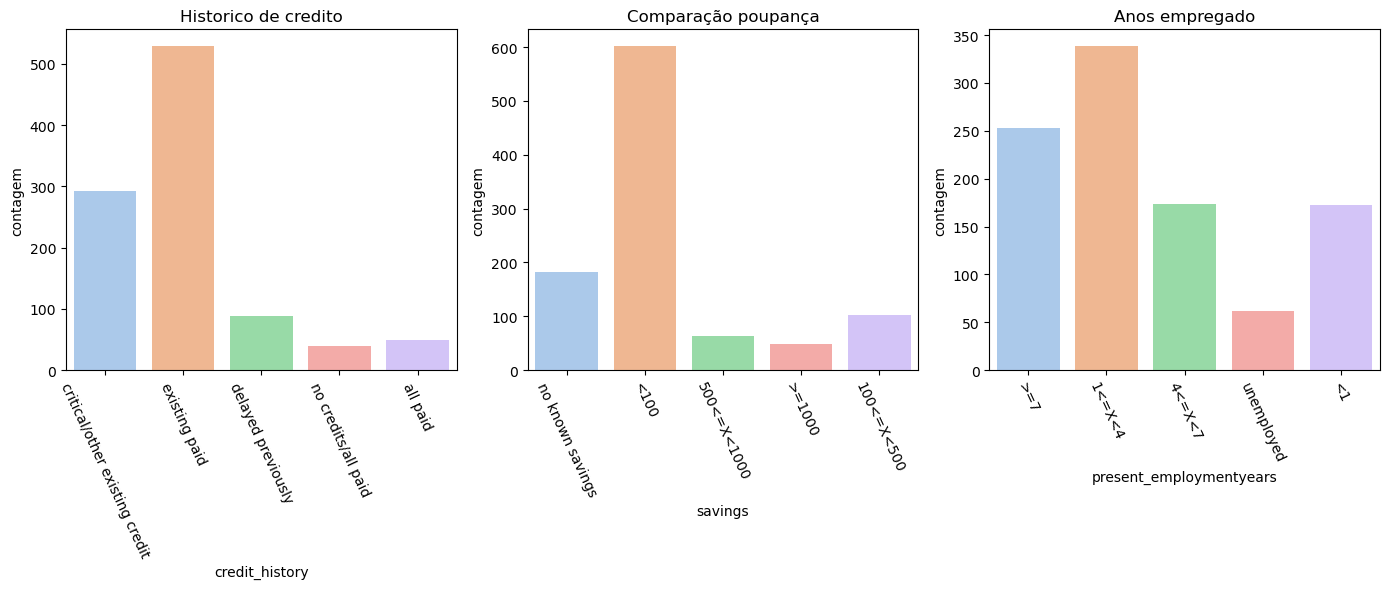

In [156]:
fig, axes = plt.subplots(1,3, figsize=(14,6))

sns.countplot(data=df, x="credit_history", hue="credit_history", palette="pastel", legend=False, ax=axes[0])
axes[0].set_title("Historico de credito")
axes[0].set_ylabel("contagem")
axes[0].tick_params(axis='x',rotation =-65)
plt.tight_layout()

sns.countplot(data=df, x="savings", hue="savings", palette="pastel", legend=False, ax=axes[1])
axes[1].set_title("Comparação poupança")
axes[1].tick_params(axis='x', rotation=-65)
axes[1].set_ylabel("contagem")
plt.tight_layout()

sns.countplot(data=df, x="present_employmentyears", hue="present_employmentyears", palette="pastel", legend=False, ax=axes[2])
axes[2].set_title("Anos empregado")
axes[2].tick_params(axis="x",rotation=-65)
axes[2].set_ylabel("contagem")
plt.tight_layout()

plt.show()


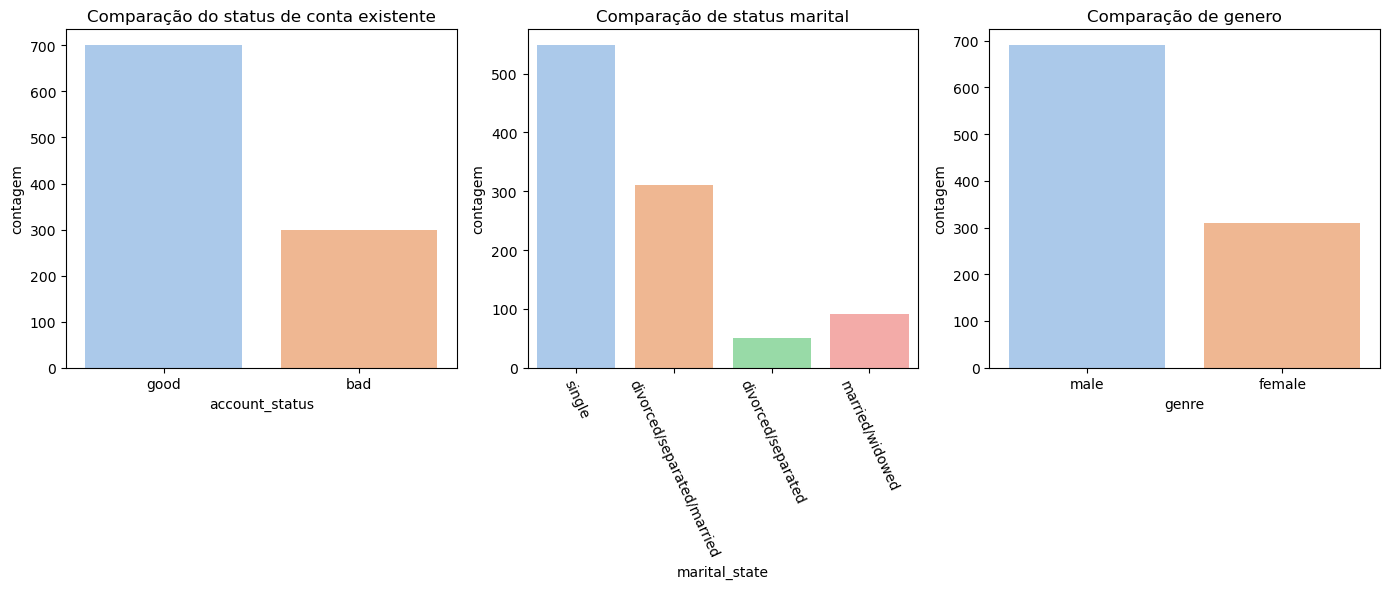

marital_state
single                        0.548
divorced/separated/married    0.310
married/widowed               0.092
divorced/separated            0.050
Name: proportion, dtype: float64


account_status
good    0.7
bad     0.3
Name: proportion, dtype: float64


genre
male      0.69
female    0.31
Name: proportion, dtype: float64


In [157]:
fig, axes = plt.subplots(1,3, figsize=(14,6))

sns.countplot(data=df, x="account_status", hue="account_status", palette="pastel", legend=False, ax=axes[0])
axes[0].set_title("Comparação do status de conta existente")
axes[0].set_ylabel("contagem")
plt.tight_layout()

sns.countplot(data=df, x="marital_state", hue="marital_state", palette="pastel", legend=False, ax=axes[1])
axes[1].set_title("Comparação de status marital")
axes[1].tick_params(axis='x', rotation=-65)
axes[1].set_ylabel("contagem")
plt.tight_layout()

sns.countplot(data=df, x="genre", hue="genre", palette="pastel", legend=False, ax=axes[2])
axes[2].set_title("Comparação de genero")
axes[2].set_ylabel("contagem")
plt.tight_layout()


plt.show()

print(f"{df['marital_state'].value_counts(normalize=True)}")
print(f"\n\n{df['account_status'].value_counts(normalize=True)}")
print(f"\n\n{df['genre'].value_counts(normalize=True)}")

No 1° grafico, Comparação do status de conta existente:
Pode-se perceber que os dados estão desbalanceados, 70% do dataset são bons pagadores e 30% não.

No 2° grafico Comparação de status marital:
Em sua maioria os clientes do dataset são solteiros, 54.8%

No 3° grafico Comparação de genero:
Podemos ver que a maior parte do dataset é composto de pessoas do genero masculino, 69%

verificar dados gerais do dataset

In [158]:
df.describe()

,duration_in_months,credit_amount,installment_rate_pct,years_at_residence,age,existing_credits_at_bank,depndets
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


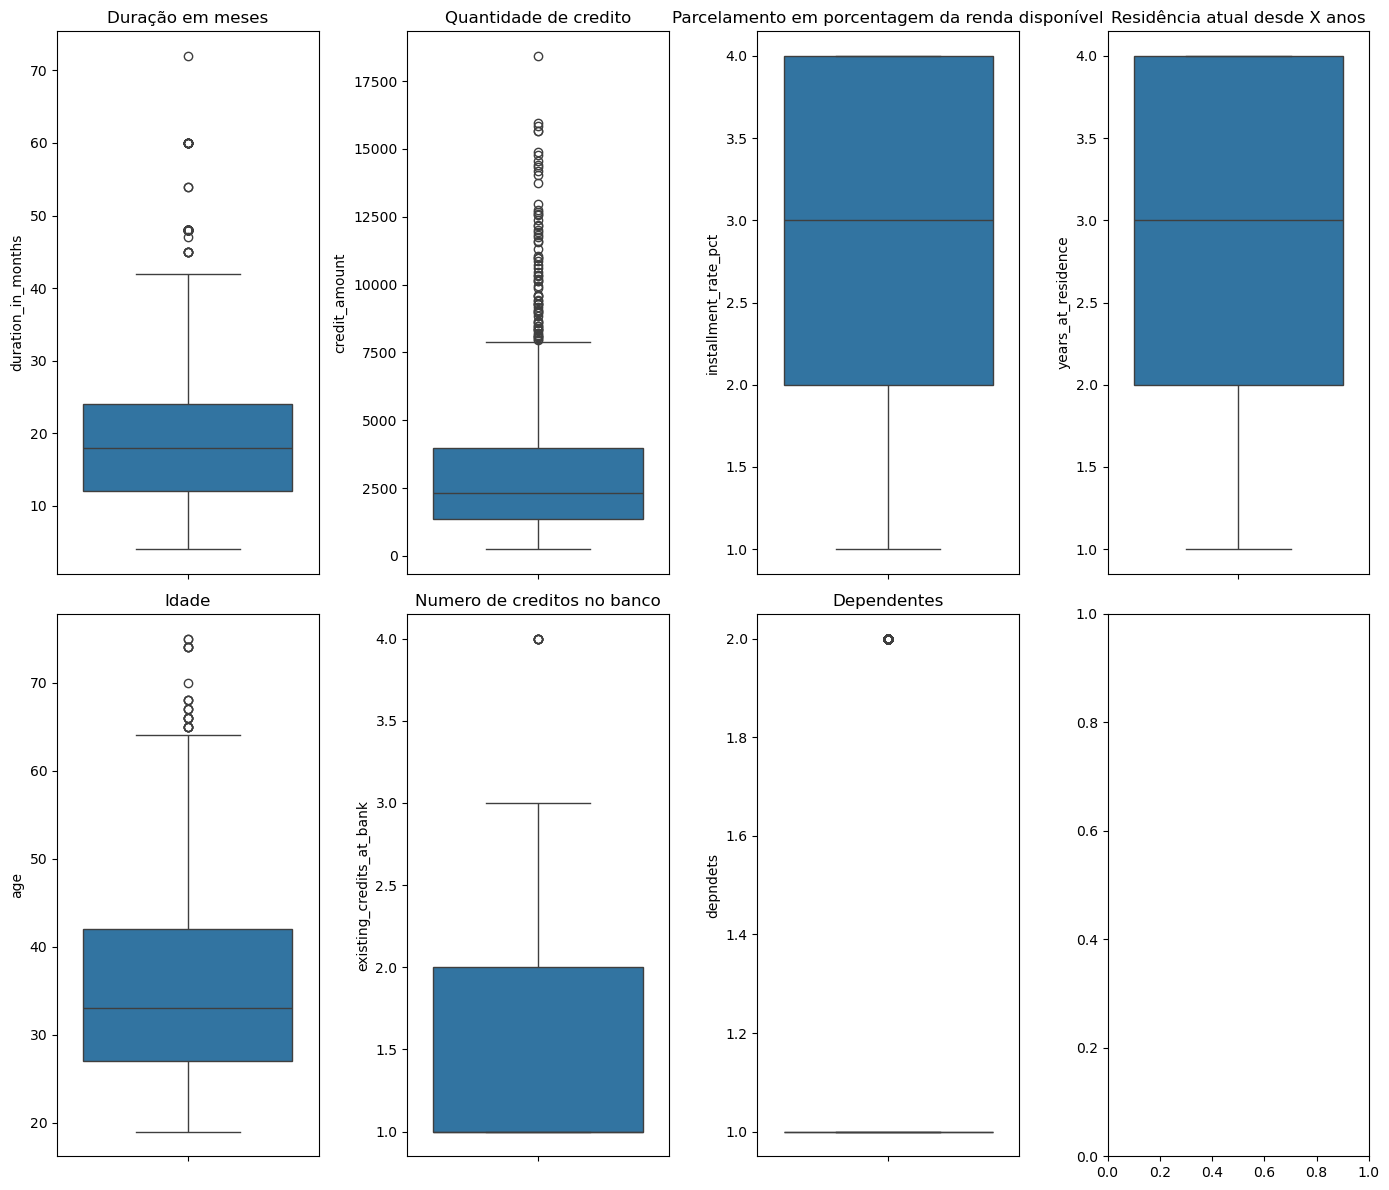

In [159]:
# criando grade de plots 
fig, axes = plt.subplots(2, 4, figsize=(14, 12))

# aplicando cada boxplot a sua respectiva posição

sns.boxplot(data=df, y="duration_in_months", ax=axes[0][0])
axes[0][0].set_title("Duração em meses")
plt.tight_layout()

sns.boxplot(data=df, y="credit_amount", ax=axes[0][1])
axes[0][1].set_title("Quantidade de credito")
plt.tight_layout()

sns.boxplot(data=df, y="installment_rate_pct", ax=axes[0][2])
axes[0][2].set_title("Parcelamento em porcentagem da renda disponível")
plt.tight_layout()

sns.boxplot(data=df, y="years_at_residence", ax=axes[0][3])
axes[0][3].set_title("Residência atual desde X anos")
plt.tight_layout()

sns.boxplot(data=df, y="age", ax=axes[1][0])
axes[1][0].set_title("Idade")
plt.tight_layout()

sns.boxplot(data=df, y="existing_credits_at_bank", ax=axes[1][1])
axes[1][1].set_title("Numero de creditos no banco")
plt.tight_layout()

sns.boxplot(data=df, y="depndets", ax=axes[1][2])
axes[1][2].set_title("Dependentes")
plt.tight_layout()



plt.show()

Não há uma grande variância visível na maior parte das coluna, com exceção de "Duration in months", "credit amount" e "Age in years", que apresentam um salto entre o quartil de 75% e o seu maximo, podendo indicar presença de outliers


In [160]:
# verificar dados gerais do dataset apos a criação dos novos features
df.describe()

,duration_in_months,credit_amount,installment_rate_pct,years_at_residence,age,existing_credits_at_bank,depndets
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [161]:
#função para contar numero de outliers presentes nas colunas
def count_outliers(df):
    outlier_counts = {}
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = outliers.shape[0]
    return pd.Series(outlier_counts, name='Outlier Count')

print(count_outliers(df))

duration_in_months           70
credit_amount                72
installment_rate_pct          0
years_at_residence            0
age                          23
existing_credits_at_bank      6
depndets                    155
Name: Outlier Count, dtype: int64


Não ha uma quantidade relevante de outliers nas colunas com exceção de "credit_amount", "duration_in_months" e "depndets". 

In [ ]:
# verificando valores da coluna
df[['dependents']].value_counts()

depndets
1           845
2           155
Name: count, dtype: int64

A coluna "dependents" apresenta apenas dois valores neste dataset: 1 e 2. Embora, ao aplicar métodos estatísticos tradicionais como o IQR (Interquartile Range), o valor 2 possa ser identificado como um outlier devido à sua menor frequência, ele representa aproximadamente 15,5% dos dados, o que configura uma proporção significativa.

Além disso, é importante destacar que esta variável não é necessariamente restrita aos valores 1 e 2 em seu domínio original, podendo assumir outros valores inteiros em diferentes contextos ou amostras.

Portanto, aplicar técnicas de remoção ou ajuste de outliers nesse caso poderia introduzir viés na análise ou nos modelos de machine learning, comprometendo a representatividade da variável.

Assim, opta-se por não realizar tratamento de outliers nessa coluna, respeitando sua natureza discreta e categórica no contexto atual dos dados.

In [163]:
#função para winsorização
def winsorize_series(series, lower_quantile=0.02, upper_quantile=0.98):
    lower = series.quantile(lower_quantile)
    upper = series.quantile(upper_quantile)
    return series.clip(lower=lower, upper=upper)

#winsorização - escala ampla com valores importantes
df['credit_amount'] = winsorize_series(df['credit_amount'])
df['duration_in_months'] = winsorize_series(df['duration_in_months'])

In [164]:
# verificando alterações nos outliers
print(count_outliers(df))

# validando alterações nos valores
df.describe()

duration_in_months           70
credit_amount                72
installment_rate_pct          0
years_at_residence            0
age                          23
existing_credits_at_bank      6
depndets                    155
Name: Outlier Count, dtype: int64


,duration_in_months,credit_amount,installment_rate_pct,years_at_residence,age,existing_credits_at_bank,depndets
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.724000,3233.312400,2.973000,2.845000,35.546000,1.407000,1.155000
std,11.490512,2660.739374,1.118715,1.103718,11.375469,0.577654,0.362086
min,6.000000,570.020000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,48.000000,12169.700000,4.000000,4.000000,75.000000,4.000000,2.000000


A quantidade de outliers continua a mesma, porem ao aplicarmos a winsorização seus valores foram amenizados

### Feature engineering

Criando novos features, com base nos existentes, visando facilitar o entendimento dos padrões para os modelos.

In [165]:
df['high_savings'] = df['savings'].isin(['500<=X<1000', '>=1000']).astype(int)
df['stable_employment'] = df['present_employmentyears'].isin(['>=7', '4<=x<7']).astype(int)



df['months>=18_high_credit'] = (((df['duration_in_months'] >= 18) & (df['credit_amount'] >= 2500))).astype(int)
df['months>=18_low_credit'] = (((df['duration_in_months'] >= 18) & (df['credit_amount'] <=2500))).astype(int)

df['months<=18_high_credit'] = (((df['duration_in_months'] <=18) & (df['credit_amount'] >= 2500))).astype(int)
df['months<=18_low_credit'] = (((df['duration_in_months'] <=18) & (df['credit_amount'] <= 2500))).astype(int)

df['older_low_credit'] = (((df['age'] >=33) & (df['credit_amount'] <= 2500))).astype(int)
df['older_high_credit'] = (((df['age'] >=33) & (df['credit_amount'] >= 2500))).astype(int)

df['young_low_credit'] = (((df['age'] <33) & (df['credit_amount'] <= 2500))).astype(int)
df['young_high_credit'] = (((df['age'] <33) & (df['credit_amount'] >= 2500))).astype(int)

df['older_credit_duration'] = (((df['age'] >=33) & (df['duration_in_months'] >= 18))).astype(int)
df['young_credit_duration'] = (((df['age'] <33) & (df['duration_in_months'] >= 18))).astype(int)

df['existing_credit_long_residing'] = (((df['existing_credits_at_bank']>1) & (df['years_at_residence'] >= 3))).astype(int)


df['credit_per_month'] = df['credit_amount'] / df['duration_in_months']
df['credit_per_year'] = df['credit_amount'] / df['age']


In [166]:
print(df['account_status'].value_counts())
print(df['genre'].value_counts())
print(df['foreign_worker'].value_counts())

account_status
good    700
bad     300
Name: count, dtype: int64
genre
male      690
female    310
Name: count, dtype: int64
foreign_worker
yes    963
no      37
Name: count, dtype: int64


As veriaveis acima são binarias, porem estão em formato de texto, estas devem ter seus valores alterados para 0 e 1.

In [167]:
df['account_status'] = df['account_status'].map({'good': 0, 'bad': 1})
df['genre'] = df['genre'].map({'female': 0, 'male': 1})
df['foreign_worker'] = df['foreign_worker'].map({'no': 0, 'yes': 1})

len(df.columns)
# one-hot enconde
df = pd.get_dummies(df)
len(df.columns)

71

Os valores foram corrigidoes e foi aplicado o one hot encode

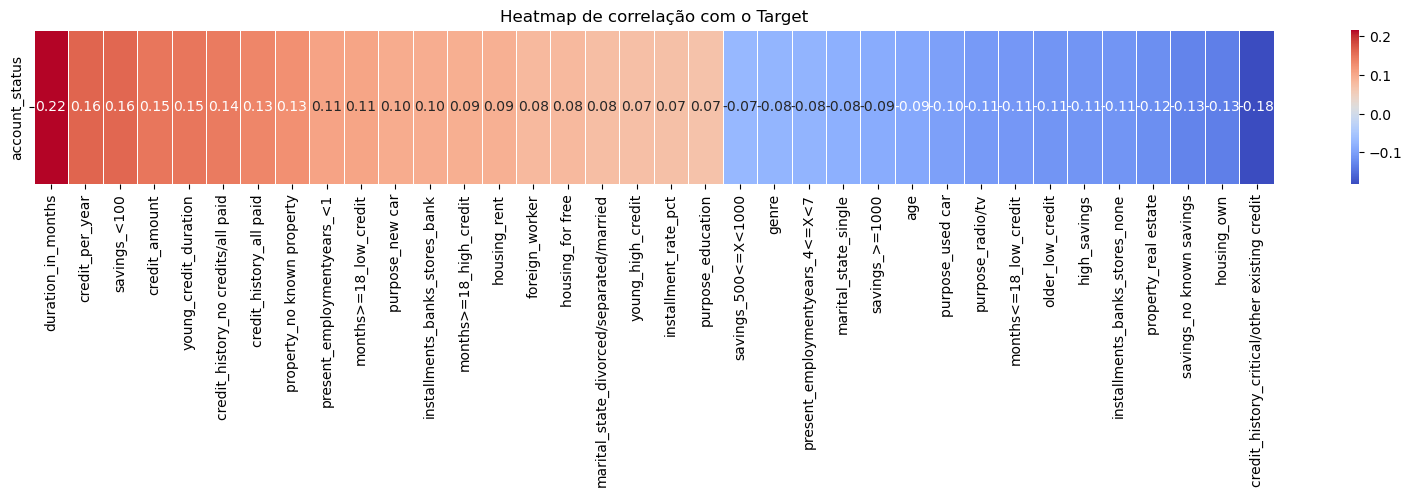

In [168]:

#inadimplente = 1
target = 'account_status'

corr = df.corr()
corr_target = corr[target]

# Filtra: correlações maiores que 7%, exclui o próprio target
corr_target_filtered = corr_target[(abs(corr_target) >= 0.07) & (corr_target.index != target)]

# Ordena
corr_target_filtered = corr_target_filtered.sort_values(ascending=False)

# Converte para DataFrame 2D
corr_target_df = corr_target_filtered.to_frame().T  # Transposto para ter as variáveis no eixo X

plt.figure(figsize=(20, 2))  # Altura menor, pois é uma linha só
axis_corr = sns.heatmap(
    corr_target_df,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.7
)

plt.title('Heatmap de correlação com o Target')

plt.show()


Podemos observar que as correlações mais relevantes são:
- Duração do crédito: correlação positiva. Pode-se supor que um tempo maior para o pagamento do credito implica que mais imprevistos podem acontecer o que pode causar uma maior taxa de inadinplencia
- Possuir crédito em outro banco: correlação negativa. Pode-se supor que um cliente que possui credito em outro banco é capaz de arcar com os custos do credito
- Status da conta de reserva < 100: correlação positiva. Supõem-se que clientes que não tenham reservas tenham maior dificuldade de pagar as parcelas
- Quantidade de crédito do cliente: correlação positiva. Supõem-se que quanto maior o credito, maior a necessidade de uma renda alta para que seja pago corretamente, tendo em vista que a maior parte do dataset não apresenta resevas acima de 100 é um indicio de que os clientes são incapazes de arcar com os custos

Considerando que a amostra de dados seja suficientemente grande para ser representativa da população, podemos inferir que a existência de crédito prévio no banco é um fator que influencia diretamente na decisão de concessão de crédito para o cliente.

Esse fator sugere que clientes que já possuem crédito podem ter uma maior probabilidade de obter novos créditos, enquanto variáveis como o montante e a duração do crédito tendem a impactar negativamente a decisão, possivelmente por estarem associadas a um maior risco de inadimplência.

### Treinamento do modelo

In [169]:
X = df.drop('account_status', axis=1) # features
y = df['account_status'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [170]:
# SMOTE pipeline 
pipeline_SMOT = Pipeline([
    ('scaler',StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# nearmiss pipeline 
pipeline_NM = Pipeline([
    ('scaler',StandardScaler()),
    ('near', NearMiss()),
    ('clf', RandomForestClassifier(random_state=42))
])

# preparando parametros dos modelos
param_grid = [
   
    {
        'clf':[LogisticRegression(max_iter=1000)],
        'clf__C':[0.01,0.1,0.2,0.5,0.8,1,1.2,1.5,10]
    },
    {
        'clf':[KNeighborsClassifier()],
        'clf__n_neighbors':list(range(1,31)),
        'clf__weights':['uniform','distance'],
        'clf__metric':['euclidean', 'manhattan', 'minkowski'],
    },
    {
        'clf': [SVC()],
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf', 'poly'],
        'clf__gamma': ['scale', 'auto']
    },
    {
        'clf':[RandomForestClassifier(random_state=42)],
        'clf__n_estimators': [100, 200, 500],
        'clf__max_depth': [None , 5, 10, 20],
        'clf__min_samples_split': [2,5,10],
        'clf__min_samples_leaf':[1,2,4],
        'clf__class_weight':['balanced']

    },
    {
        "clf":[DecisionTreeClassifier(random_state=42)],
        'clf__criterion':['gini','entropy','log_loss'],
        'clf__max_depth': [None , 5, 10, 20, 50],
        'clf__min_samples_split': [2,5,10],
        'clf__min_samples_leaf':[1,2,4],
    },
    
    {
        'clf':[GradientBoostingClassifier()],
        'clf__n_estimators': [100, 200, 500],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__max_depth': [3, 5]
    },
]

# definindo metricas de avaliação
scoring = {
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision',
    'roc_auc': 'roc_auc'
}



Neste problema, as métricas mais relevantes são o Recall e a Precision, uma vez que desejamos equilibrar dois objetivos críticos: identificar corretamente os clientes inadimplentes (maximizando o Recall) e evitar a reprovação indevida de bons pagadores (maximizando a Precision). 

Dado esse cenário, foi selecionado o F1-Score como a principal métrica de avaliação, pois representa a média harmônica entre Precision e Recall, penalizando modelos que apresentam desempenho desequilibrado entre estas duas métricas.

In [171]:
# definindo parametros do GridSearch com SMOT
grid_search_st = GridSearchCV(pipeline_SMOT, param_grid, cv=5, scoring=scoring, refit='f1', n_jobs=-1)
grid_search_st.fit(X_train, y_train)


# definindo parametros do GridSearch com nearmiss
grid_search_nm = GridSearchCV(pipeline_NM, param_grid, cv=5, scoring=scoring, refit='f1', n_jobs=-1)
grid_search_nm.fit(X_train, y_train)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('near', NearMiss()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf': [LogisticRegression(max_iter=1000)],
                          'clf__C': [0.01, 0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5,
                                     10]},
                         {'clf': [KNeighborsClassifier()],
                          'clf__metric': ['euclidean', 'manhattan',
                                          'minkowski'],
                          'clf__n_neigh...
                          'clf__criterion': ['gini', 'entropy', 'log_loss'],
                          'clf__max_depth': [None, 5, 10, 20, 50],
                          'clf__min_samples_leaf': [1, 2, 4],
                          'clf__min_samples_split': [2, 5, 10]},
                         {'clf': [GradientBoostingClassifier()],
                          'clf__learning_rate': [0.01, 0.05, 0.1],
                          'clf__max_depth': [3, 5],
                          'clf__n_estimators': [100, 200, 500]}],
             refit='f1',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

### Avaliação dos modelos

#### Comparação dos resultados do treinamento com NearMiss e SMOTE

In [172]:

'''
Recebe um objeto GridSearchCV, transforma os resultados em um DataFrame e adiciona o nome do modelo testado.
Para cada modelo, seleciona a melhor combinação de hiperparâmetros com base na métrica F1-score e cria gráficos de barras mostrando F1, Recall, Precision e ROC AUC.
Por fim, imprime as melhores combinações e métricas para análise detalhada de cada modelo.
'''

def avaliacao_grid_search(grid_search, name):
    # Transforma os resultados em DataFrame para facilitar a visualização
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Criar coluna com nome do modelo
    results_df['model_name'] = results_df['param_clf'].apply(lambda x: type(x).__name__)

    # Encontrar o melhor resultado de cada modelo
    best_per_model = results_df.loc[results_df.groupby('model_name')['mean_test_f1'].idxmax()]

    # Configurar o subplot 3x2 → 6 espaços (sobra 1)
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))
    axes = axes.flatten()  # Facilita iteração

    # Para cada modelo, criar um gráfico de barras
    for i, (idx, row) in enumerate(best_per_model.iterrows()):
        model = row['model_name']
        metrics = {
            'F1': row['mean_test_f1'],
            'Recall': row['mean_test_recall'],
            'Precision': row['mean_test_precision'],
            'ROC AUC': row['mean_test_roc_auc']
        }
        
        ax = axes[i]
        ax.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightgreen', 'salmon', 'orange'])
        ax.set_ylim(0, 1)
        ax.set_title(f'Métricas - {model} ({name})')
        ax.set_ylabel('Score')
        ax.set_xlabel('Métrica')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Se sobrar espaço, remover plot vazio
    if len(best_per_model) < len(axes):
        for j in range(len(best_per_model), len(axes)):
            fig.delaxes(axes[j])

    # Ajustar o layout para não sobrepor textos
    plt.tight_layout()
    plt.show()

    colum = best_per_model['model_name']
    for c in colum:
        # Filtrar apenas DecisionTree
        dt_results = results_df[results_df['model_name'] == c]

        # Encontrar o índice da melhor combinação (maior F1)
        best_idx = dt_results['mean_test_f1'].idxmax()

        #arvore de decisão
        print(f"Melhor combinação de hiperparâmetros para {c}:")
        print(results_df.loc[best_idx, 'params'])

        print("\nMétricas da melhor combinação:")
        print(f"F1: {results_df.loc[best_idx, 'mean_test_f1']:.4f}")
        print(f"Recall: {results_df.loc[best_idx, 'mean_test_recall']:.4f}")
        print(f"Precision: {results_df.loc[best_idx, 'mean_test_precision']:.4f}")
        print(f"ROC AUC: {results_df.loc[best_idx, 'mean_test_roc_auc']:.4f}\n")




#### SMOTE

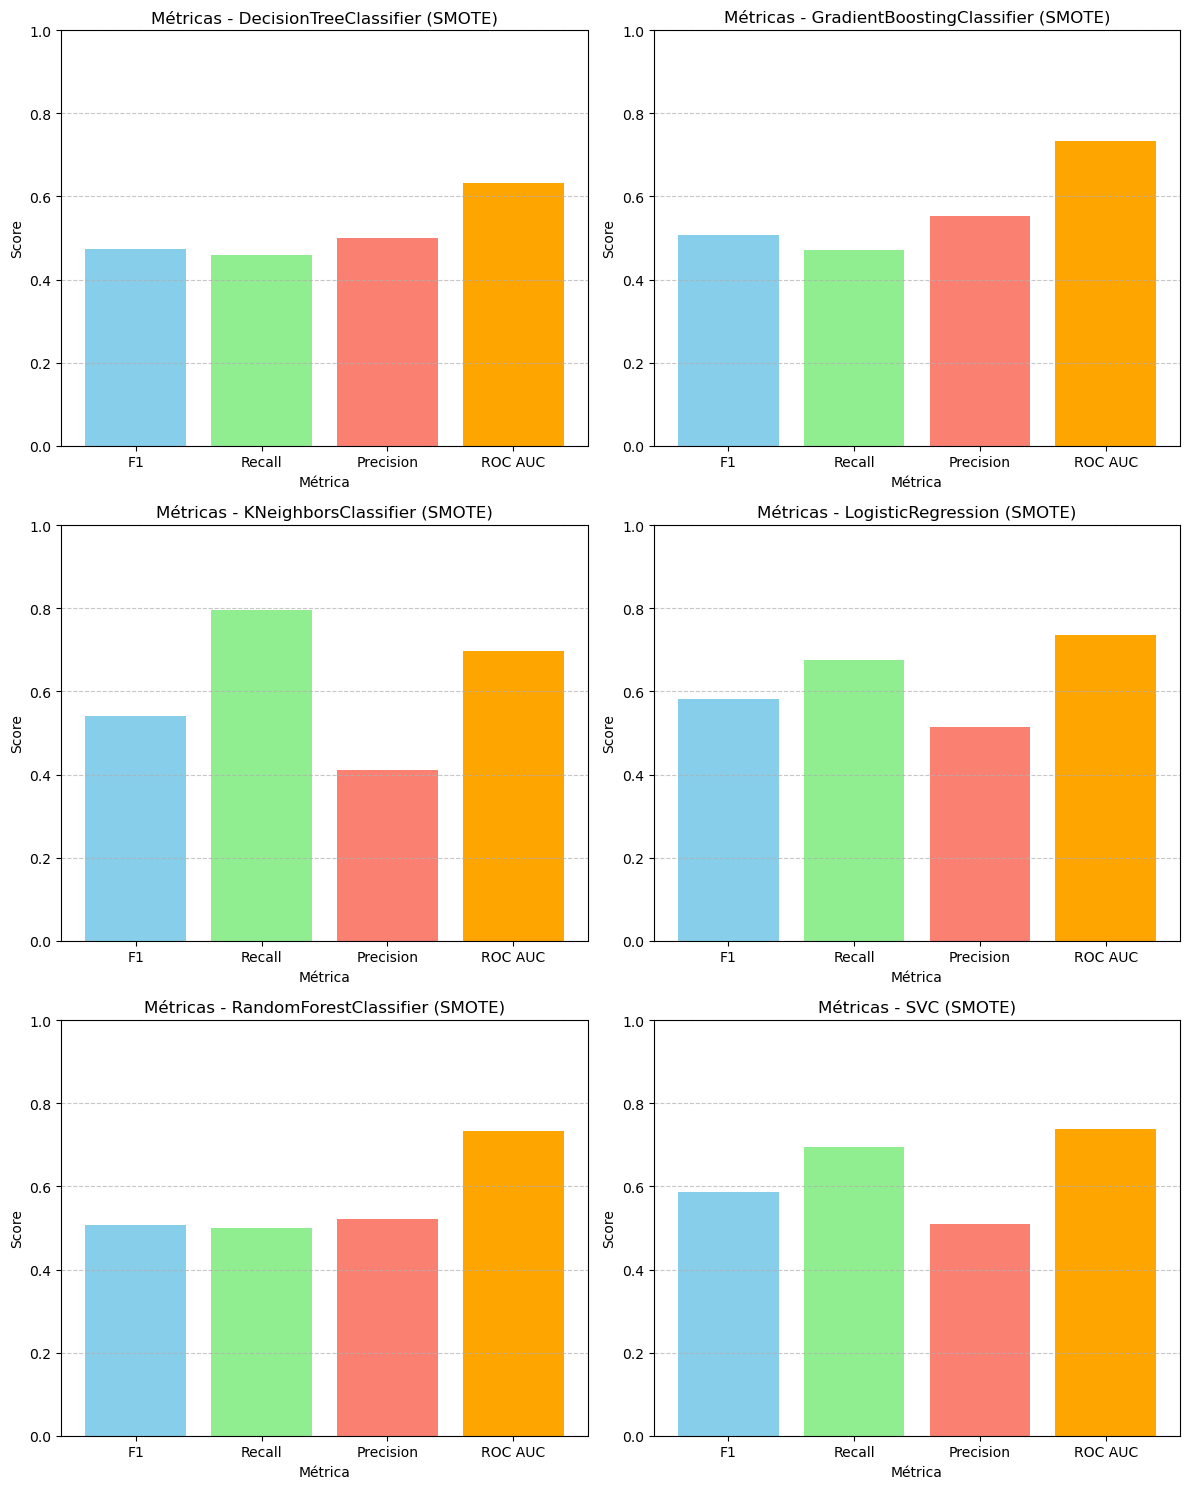

Melhor combinação de hiperparâmetros para DecisionTreeClassifier:
{'clf': DecisionTreeClassifier(random_state=42), 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}

Métricas da melhor combinação:
F1: 0.4744
Recall: 0.4583
Precision: 0.4992
ROC AUC: 0.6326

Melhor combinação de hiperparâmetros para GradientBoostingClassifier:
{'clf': GradientBoostingClassifier(), 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 500}

Métricas da melhor combinação:
F1: 0.5074
Recall: 0.4708
Precision: 0.5529
ROC AUC: 0.7343

Melhor combinação de hiperparâmetros para KNeighborsClassifier:
{'clf': KNeighborsClassifier(), 'clf__metric': 'euclidean', 'clf__n_neighbors': 26, 'clf__weights': 'uniform'}

Métricas da melhor combinação:
F1: 0.5421
Recall: 0.7958
Precision: 0.4117
ROC AUC: 0.6977

Melhor combinação de hiperparâmetros para LogisticRegression:
{'clf': LogisticRegression(max_iter=1000), 'clf__C': 0.2}

Métricas da melhor com

In [173]:
avaliacao_grid_search(grid_search_st, "SMOTE")

Os modelos com melhores resultados usando o metodo de balanceamento SMOTE foram LinearRegression e SVC

| model | F1-score | Recall | precision |
|---|---|---|---|
| LogisticRegression |58.2|67.9|51.3|
| SVC | 57.7 | 68.3 | 50.5 |

#### NearMiss

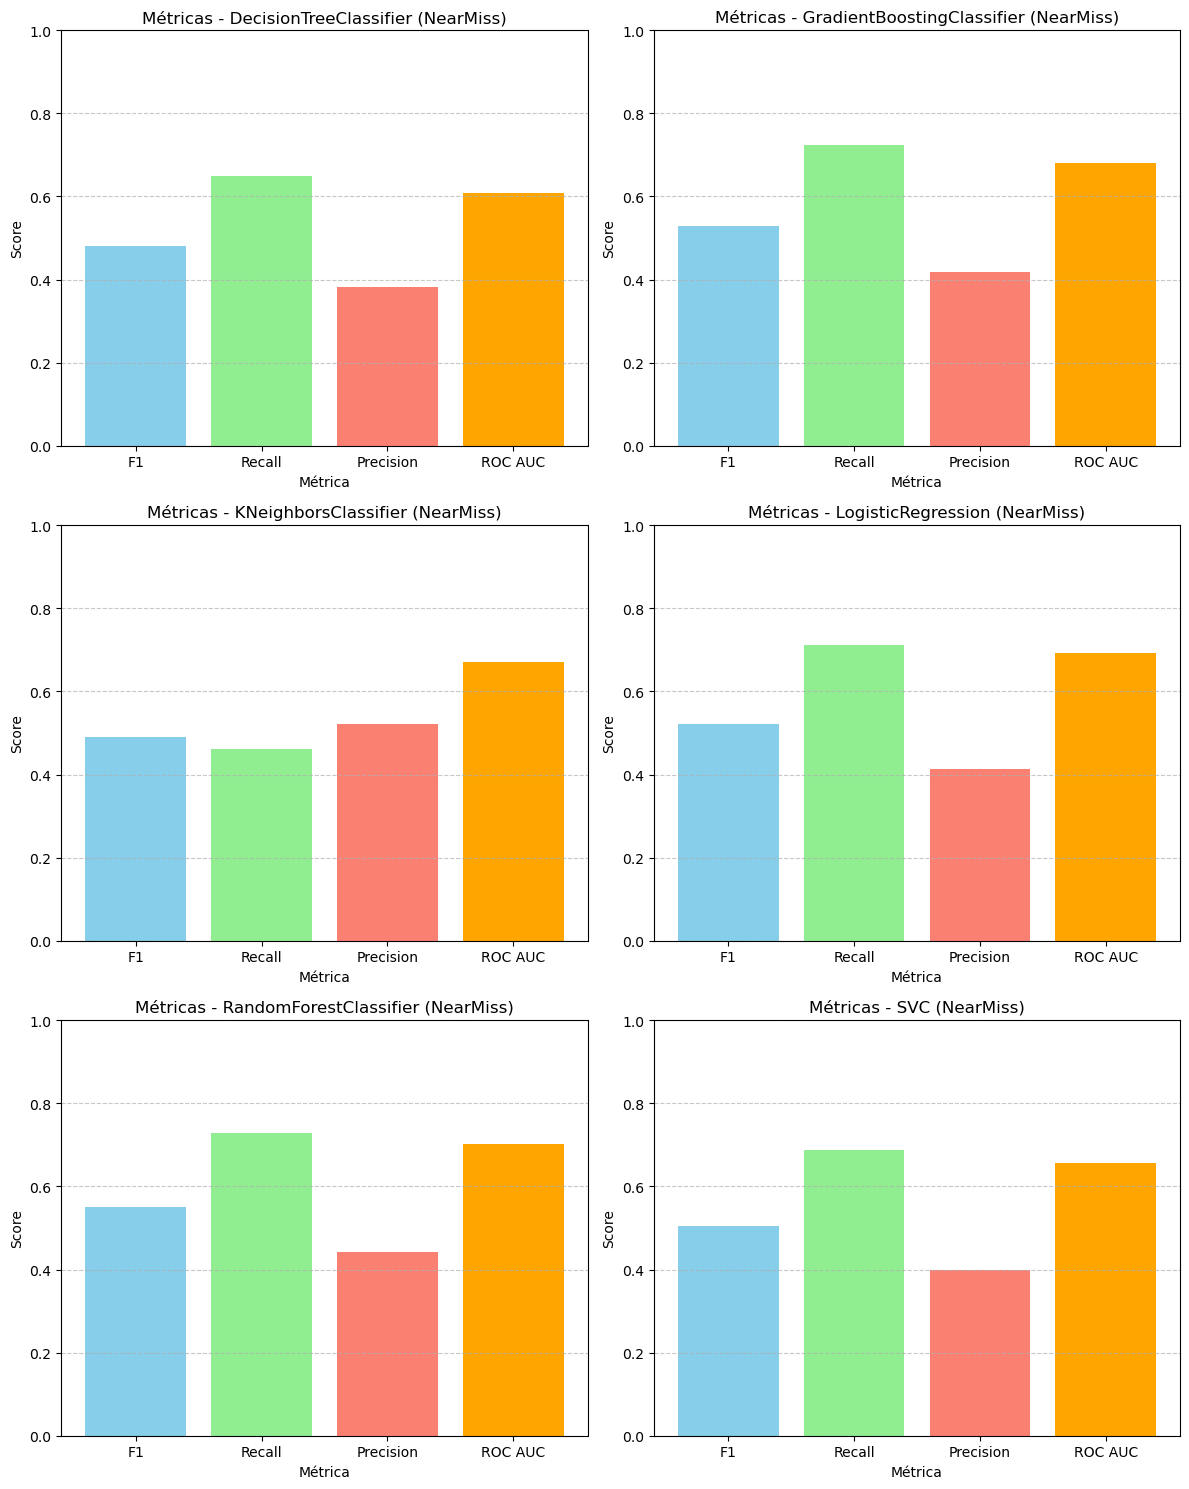

Melhor combinação de hiperparâmetros para DecisionTreeClassifier:
{'clf': DecisionTreeClassifier(random_state=42), 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}

Métricas da melhor combinação:
F1: 0.4804
Recall: 0.6500
Precision: 0.3829
ROC AUC: 0.6076

Melhor combinação de hiperparâmetros para GradientBoostingClassifier:
{'clf': GradientBoostingClassifier(), 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100}

Métricas da melhor combinação:
F1: 0.5282
Recall: 0.7250
Precision: 0.4172
ROC AUC: 0.6818

Melhor combinação de hiperparâmetros para KNeighborsClassifier:
{'clf': KNeighborsClassifier(), 'clf__metric': 'euclidean', 'clf__n_neighbors': 7, 'clf__weights': 'distance'}

Métricas da melhor combinação:
F1: 0.4893
Recall: 0.4625
Precision: 0.5209
ROC AUC: 0.6705

Melhor combinação de hiperparâmetros para LogisticRegression:
{'clf': LogisticRegression(max_iter=1000), 'clf__C': 0.01}

Métricas da melhor 

In [174]:
avaliacao_grid_search(grid_search_nm, "NearMiss")

Os melhores resultados usando o metodo de balancemaneto NearMiss foram GradientBoosting e RandomForestClassifier:

| model | F1-score | Recall | precision |
|---|---|---|---|
| GradientBoosting |53.5|73.3|42.2|
| RandomForestClassifier | 54.1 | 72.5 | 43.3 |

### SMOTE vs NearMiss

Os resultados em ambos os casos deixaram a desejar, apresentando um precisão baixa e tornando o modelo pouco viavel para o uso. Porém entre as duas opções a opção com SMOTE apresentou resultados um pouco melhores do que a do NearMiss, com a precisão dos melhores modelos perto de 50% contra aproximadamente 43%.

Desse modo seguiremos com os modelos treinados com oversampling buscando melhorar seu desempenho.

### Comparando LinearRegression e SVC

Testando modelos com os melhores resultados apresentados

Resultados do modelo:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=0.2))])


c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


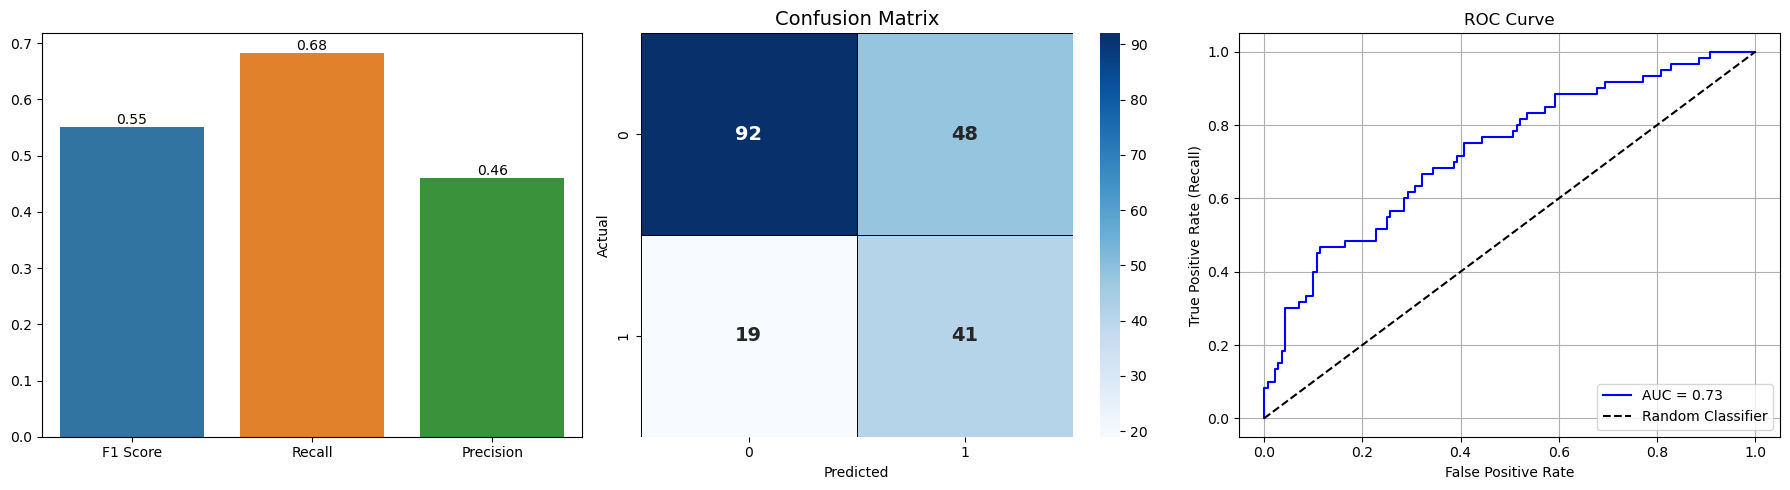




Resultados do modelo:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=0.1, kernel='linear'))])





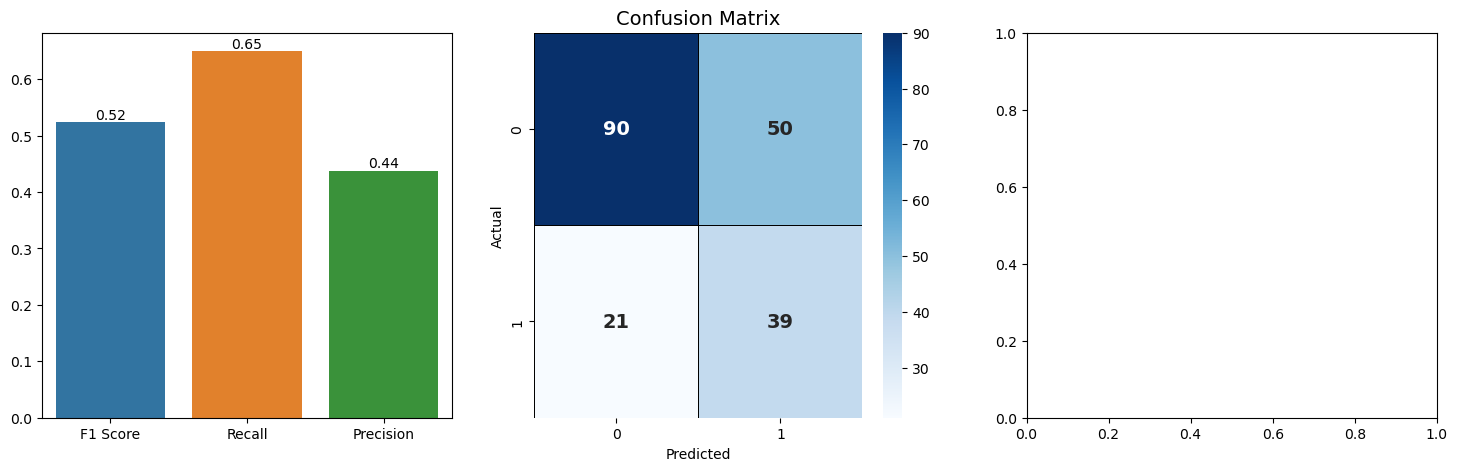

In [175]:
# testar modelo gradient e RF com sample de teste
# Transforma os resultados em DataFrame para facilitar a visualização
results_df = pd.DataFrame(grid_search_st.cv_results_)

# Criar coluna com nome do modelo
results_df['model_name'] = results_df['param_clf'].apply(lambda x: type(x).__name__)

# Encontrar o melhor resultado de cada modelo
best_per_model = results_df.loc[results_df.groupby('model_name')['mean_test_f1'].idxmax()]

# Filtra o melhores modelo

melhor_lr = best_per_model[best_per_model['model_name'] == "LogisticRegression"].iloc[0]
melhor_svc = best_per_model[best_per_model['model_name'] == "SVC"].iloc[0]



# Seleciona os parâmetros
params_lr = melhor_lr['params']
params_svc = melhor_svc['params']


lr_model = Pipeline([
           ('scaler', StandardScaler()),
           ('clf',LogisticRegression(**{k.split('__')[1]: v for k, v in params_lr.items() if '__' in k}))
           ])


svc_model = Pipeline([
            ('scaler', StandardScaler()),
            ('clf',SVC(**{k.split('__')[1]: v for k, v in params_svc.items() if '__' in k}))
            ])



models = [lr_model,svc_model]



smote = SMOTE(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
for model in models:
    print("Resultados do modelo:")
    print(model)

    # Treinando os modelos
    model.fit(X_train_resampled, y_train_resampled)

    
    # Testa com dados de teste
    y_pred = model.predict(X_test_scaled)

    # Calcula metricas
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Cria dataframe com as metricas para plotar o grafico
    data_model = {'F1 Score':f1, 'Recall':recall, 'Precision':precision}
    df_model = pd.DataFrame(data=data_model, index=[0, 1, 2])
    
    
    # Plotando os graficos comparativos
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Grafico de barras
    sns.barplot(data=df_model, ax=axes[0])

    # Adicionando os valores sobre as barras 
    for p in axes[0].patches:
        height = p.get_height()
        axes[0].annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom')

    # Calculando matriz confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # plotando matriz confusão
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                linewidths = 0.5, linecolor='black', annot_kws={"size":14, "weight":"bold"}, ax = axes[1])

    axes[1].set_title('Confusion Matrix', fontsize=14)
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    #verifica modelo 
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        # Calcula curva roc
        roc_auc = roc_auc_score(y_test, y_proba)

        fpr, tpr, thresholds = roc_curve(y_test, y_proba)

        # Plotar curva roc
        axes[2].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
        axes[2].plot([0, 1], [0, 1], 'k--', label='Random Classifier')

        axes[2].set_xlabel('False Positive Rate')
        axes[2].set_ylabel('True Positive Rate (Recall)')
        axes[2].set_title('ROC Curve')
        axes[2].legend(loc='lower right')
        axes[2].grid(True)

        plt.tight_layout()
        plt.show()
    print("\n\n")


Ao realizar o teste dos modelos com o a amostra de teste, obtivemos resultados que tornam o modelo ineficiente para o uso, deixando clara a necessidade de uma melhora em seu desempenho principalmente no quesito de precisão.

Seguimos com o modelo de RegressãoLinear por apresentar um resultado um pouco melhor em suas metricas

### Avaliação com SHAP

#### Resultados

Para entender melhor o funcionamento do modelo e a importancia de cada feature em seu treinamento fizemos uso do beeswarm do shap, mostrando os features que teriam a maior influencia tanto positiva quanto negativa no treinamento do modelos

In [176]:
# Transformar e manter como DataFrame
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,  # <- Mantém os nomes corretos
    index=X_test.index
)
clf = lr_model.named_steps['clf']

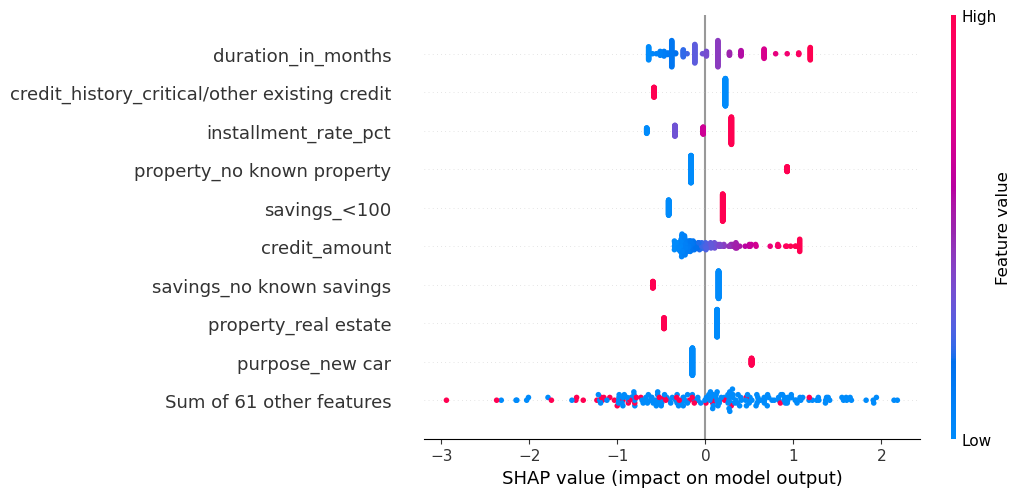

In [177]:
explainer = shap.Explainer(clf, X_test_scaled)
shap_values = explainer(X_test_scaled)
shap.plots.beeswarm(shap_values)

In [178]:
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_values_df.abs().mean().sort_values(ascending=True).head(32)

older_high_credit                           0.000058
purpose_domestic appliance                  0.001444
savings_100<=X<500                          0.001859
months>=18_high_credit                      0.003011
young_low_credit                            0.003825
existing_credit_long_residing               0.003921
age                                         0.004715
present_employmentyears_>=7                 0.007628
stable_employment                           0.007628
credit_history_delayed previously           0.008830
credit_per_month                            0.011937
debtors_guarantors_none                     0.013305
job_unemp/unskilled non res                 0.013651
housing_own                                 0.013715
purpose_repairs                             0.014485
job_skilled                                 0.016351
debtors_guarantors_co applicant             0.019079
property_life insurance                     0.020739
installments_banks_stores_stores            0.

Após avaliar a importancia dos features no modelo notamos que grande parte deles tem um influencia minima no resultado das predições, o que pode estar fazendo com que o modelo tenha um desempenho pior.

Removendo os features menos relevantes para o modelo, apos alguns testes realizados chegamos ao resultado de que o melhor desempenho obtido com o modelo vem com a remoção dos features que tem menos de 7% de influencia no treinamento do modelo

In [179]:
# Step 1: Get mean absolute SHAP values per feature
mean_importance = shap_values_df.abs().mean()

# Step 2: Select features with importance >= 0.07
important_features = mean_importance[mean_importance >= 0.07].index.tolist()

# Step 3: Filter your original datasets
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

Mesmo com a melhora vinda da remoção das colunas dos features menos relevantes, o modelo ainda apreentava valores pouco satisfatorios, tornando necessario a definição de um valor de threshold maior, fasendo uma troca de Recall por Precision.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Resultados do modelo:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=0.2))])


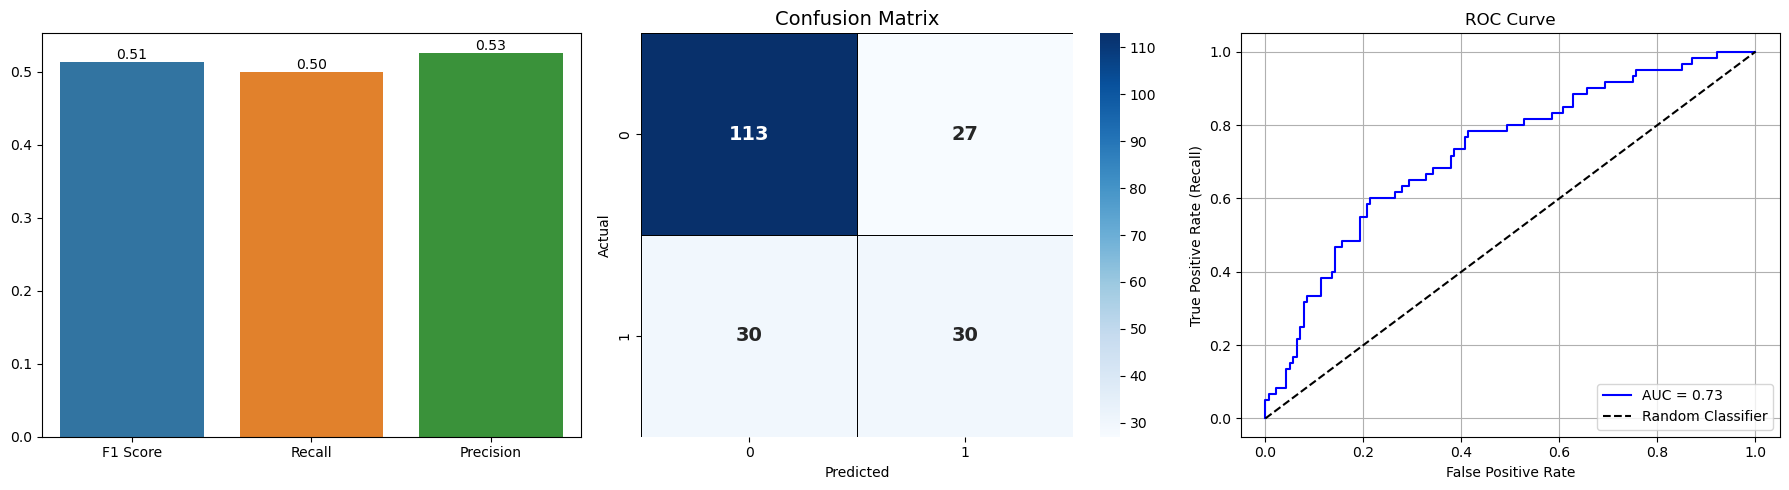

In [180]:
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
model = lr_model
print("Resultados do modelo:")
print(model)

# Treinando os modelos
model.fit(X_train_resampled, y_train_resampled)


# Testa com dados de teste
# Get predicted probabilities
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# custom threshold (e.g., 0.66)
threshold = 0.66
y_pred = (y_proba >= threshold).astype(int)

# Calcula metricas
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Cria dataframe com as metricas para plotar o grafico
data_model = {'F1 Score':f1, 'Recall':recall, 'Precision':precision}
df_model = pd.DataFrame(data=data_model, index=[0, 1, 2])


# Plotando os graficos comparativos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Grafico de barras
sns.barplot(data=df_model, ax=axes[0])

# Adicionando os valores sobre as barras 
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

# Calculando matriz confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# plotando matriz confusão
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            linewidths = 0.5, linecolor='black', annot_kws={"size":14, "weight":"bold"}, ax = axes[1])

axes[1].set_title('Confusion Matrix', fontsize=14)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

#verifica modelo 
if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    # Calcula curva roc
    roc_auc = roc_auc_score(y_test, y_proba)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # Plotar curva roc
    axes[2].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
    axes[2].plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate (Recall)')
    axes[2].set_title('ROC Curve')
    axes[2].legend(loc='lower right')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

Após essa troca e alguns testes realizados, chegamos ao thresholod de 0.66 como sendo o mais eficiente, mantendo o maximo possivel do recal e subindo o maximo possivel de precision deixando o modelo com os seguintes valores em sua metrica:

|f1-score|recall|precision|auc-roc|
|---|---|---|---|
|56|55|57|73|

As metricas obtidas indicam um modelo moderado, mostrando-se capaz de prever corretamente porém não sendo tão confiavel em suas predições (precision 57%).

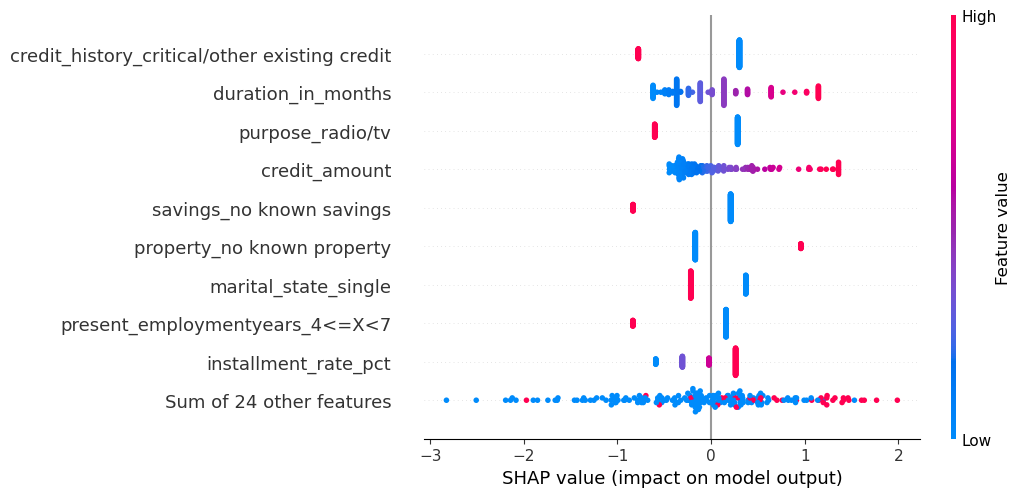

In [181]:
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_filtered),
    columns=X_test_filtered.columns,  # <- Mantém os nomes corretos
    index=X_test_filtered.index
)

explainer = shap.Explainer(clf, X_test_scaled)
shap_values = explainer(X_test_scaled)
shap.plots.beeswarm(shap_values)

In [182]:
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test_filtered.columns)
shap_values_df.abs().mean().sort_values(ascending=False).head(10)

credit_history_critical/other existing credit    0.428271
duration_in_months                               0.402635
purpose_radio/tv                                 0.386993
credit_amount                                    0.344742
savings_no known savings                         0.330596
property_no known property                       0.287481
marital_state_single                             0.280106
present_employmentyears_4<=X<7                   0.277561
installment_rate_pct                             0.274091
months>=18_low_credit                            0.215130
dtype: float64

### Conclusão

O modelo pode ser usado para o auxilio na tomada de decisões, porém não apresenta uma alta confiabilidade, devido ao baixo valor de precisão e recall obtido. Isso pode ter ocorrido devido a pouca quantidade de dados disponiveis para seu treinamento, onde em sua maioria seriam bons pagadores (70%), o que dificulta o modelo a identificar padrões na predição de potenciais inadinplencias.

Uma maior quantidade de dados diponiveis auxiliaria no treinamento de um modelo mais eficiente. Estes poderiam ser coletados manualmente com o tempo, ou gerados de maneira sintetica, porém a criação de mais dados sinteticos, como ja fazemos uso de SMOTE, pode introduzir vies ao modelo gerando overfitting, por se basearem em uma amostra pequena.

Em suma, o modelo atual pode ser considerado um ponto de partida, mas melhorias na qualidade e quantidade dos dados são fundamentais para a construção de um sistema preditivo mais robusto e confiável.


#### Possiveis melhorias

- Aprimorar a base de dados


- Explorar técnicas avançadas de balanceamento
  - testar métodos além do SMOTE, como ADASYN, Borderline-SMOTE e SMOTE-ENN, que geram exemplos sintéticos de forma mais contextualizada

- Melhorar o feature enginearing
